What are the temporal patterns of phoneme prediction performance for a model?

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [42]:
from collections import defaultdict

import datasets
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

In [3]:
test_dataset_path = "../out/rnn/w2v2base_rnn2_hidden128_drop6/test_result"
model_sfreq = 50
tokenizer_name = "charsiu/tokenizer_en_cmu"
analysis_key = "phonemic_detail"

In [4]:
test_dataset = datasets.load_from_disk(test_dataset_path)

In [5]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Exploratory accuracy analyses

In [6]:
playground = test_dataset.select(range(100))

In [24]:
phoneme_vocab = tokenizer.get_vocab()
max_track_width = 30
accuracy_results = []

for item in playground:
    num_frames = item["real_frames"]
    compression_ratio = item["compression_ratio"]

    # For every frame, track which phoneme has span over that frame.
    # TODO could be multiple
    phoneme_span = np.ones(num_frames, dtype=int) * -1
    # track the global index of the phoneme spanning each frame
    phoneme_index = np.ones(num_frames, dtype=int) * -1
    # track the index of the phoneme spanning each frame, relative to word onset
    phoneme_relative_index = np.ones(num_frames, dtype=int) * -1
    # track the index of the word spanning each frame
    word_span = np.ones(num_frames, dtype=int) * -1
    j_global = 0
    for i, phonemic_detail in enumerate(item[f"word_{analysis_key}"]):
        for j, phoneme in enumerate(phonemic_detail):
            start = int(phoneme["start"] * compression_ratio)
            stop = int(phoneme["stop"] * compression_ratio)
            phoneme_span[start:stop] = phoneme_vocab[phoneme["phone"]]
            phoneme_index[start:stop] = j_global
            phoneme_relative_index[start:stop] = j
            j_global += 1

        start = int(phonemic_detail[0]["start"] * compression_ratio)
        stop = int(phonemic_detail[-1]["stop"] * compression_ratio)
        word_span[start:stop] = i

    item_id = f"{item['speaker_id']}/{item['id']}"
    predicted = np.array(item["predicted"])

    for i in range(num_frames):
        if phoneme_index[i] == -1:
            continue
        if word_span[i] == -1:
            continue

        for j in range(max(0, i - max_track_width), min(num_frames, i + max_track_width)):
            if phoneme_index[j] == -1:
                continue
            phoneme_j = phoneme_span[j]
            if phoneme_j == -1:
                continue

            accuracy_results.append({
                "item_id": item_id,
                "frame_id": i,
                "phoneme_relative_idx": phoneme_relative_index[i],
                "target_frame_id": j,
                "target_phoneme_relative_idx": phoneme_relative_index[j],
                "accuracy": predicted[i, phoneme_j],
                "distance_frames": j - i,
                "distance_phonemes": phoneme_index[j] - phoneme_index[i],
                "distance_words": word_span[j] - word_span[i],
            })

In [25]:
frame_results_df = pd.DataFrame(accuracy_results)
frame_results_df["same_word"] = frame_results_df["distance_words"] == 0
frame_results_df["same_phoneme"] = frame_results_df["distance_phonemes"] == 0
frame_results_df

,item_id,frame_id,phoneme_relative_idx,target_frame_id,target_phoneme_relative_idx,prediction,distance_frames,distance_phonemes,distance_words,same_word,same_phoneme
0,AKS0/SA1,30,0,30,0,1,0,0,0,True,True
1,AKS0/SA1,30,0,31,0,1,1,0,0,True,True
2,AKS0/SA1,30,0,32,0,1,2,0,0,True,True
3,AKS0/SA1,30,0,33,0,1,3,0,0,True,True
4,AKS0/SA1,30,0,34,0,1,4,0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...
684441,STK0/SX394,118,4,114,3,1,-4,-1,0,True,False
684442,STK0/SX394,118,4,115,3,1,-3,-1,0,True,False
684443,STK0/SX394,118,4,116,3,1,-2,-1,0,True,False
684444,STK0/SX394,118,4,117,4,1,-1,0,0,True,True


### Within-word accuracies

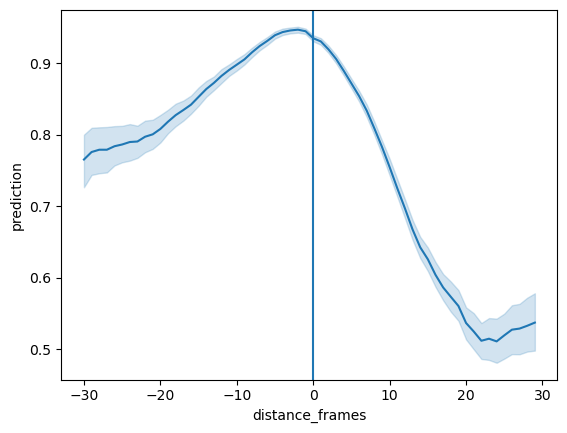

In [26]:
ax = sns.lineplot(data=frame_results_df[frame_results_df.same_word],
                  x="distance_frames", y="accuracy")
ax.axvline(0)

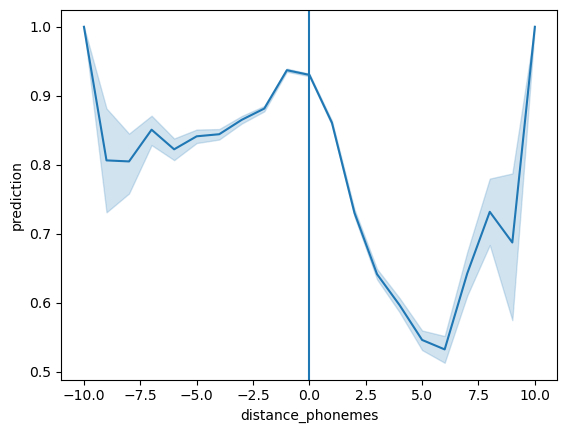

In [27]:
ax = sns.lineplot(data=frame_results_df[frame_results_df.same_word],
                  x="distance_phonemes", y="accuracy")
ax.axvline(0)

<Axes: xlabel='same_phoneme', ylabel='prediction'>

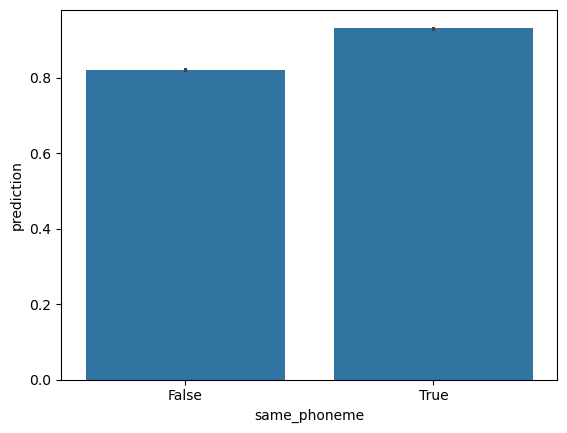

In [28]:
sns.barplot(data=frame_results_df[frame_results_df.same_word],
            x="same_phoneme", y="accuracy")

<Axes: xlabel='target_phoneme_relative_idx', ylabel='phoneme_relative_idx'>

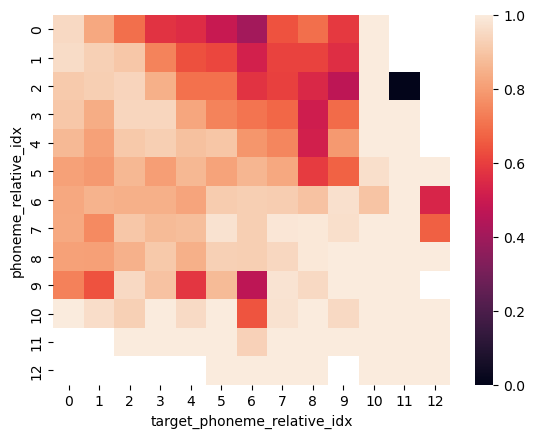

In [29]:
sns.heatmap(
    pd.pivot_table(frame_results_df[frame_results_df.same_word],
                   index="phoneme_relative_idx",
                   columns="target_phoneme_relative_idx", 
                   values="accuracy",
                   aggfunc="mean"))

### Previous-word lookback

<Axes: xlabel='distance_phonemes', ylabel='phoneme_relative_idx'>

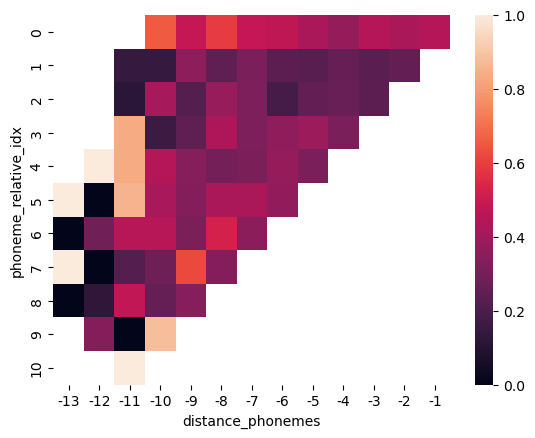

In [30]:
sns.heatmap(
    pd.pivot_table(frame_results_df[(frame_results_df.distance_words == -1)],
                   index="phoneme_relative_idx",
                   columns="distance_phonemes", 
                   values="accuracy",
                   aggfunc="mean"))


## Comprehensive ROC-AUC analysis

In [96]:
# Track model output and ground truth for within-word predictions,
# indexed by different phoneme and frame lags.
predictions_by_phoneme_lag = defaultdict(lambda: [[] for _ in range(tokenizer.vocab_size)])
predictions_by_frame_lag = defaultdict(lambda: [[] for _ in range(tokenizer.vocab_size)])

phoneme_vocab = tokenizer.get_vocab()
max_track_width = 30

for item in tqdm(playground):
    num_frames = item["real_frames"]
    compression_ratio = item["compression_ratio"]

    # For every frame, track which phoneme has span over that frame.
    # TODO could be multiple
    phoneme_span = np.ones(num_frames, dtype=int) * -1
    # track the global index of the phoneme spanning each frame
    phoneme_index = np.ones(num_frames, dtype=int) * -1
    # track the index of the phoneme spanning each frame, relative to word onset
    phoneme_relative_index = np.ones(num_frames, dtype=int) * -1
    # track the index of the word spanning each frame
    word_span = np.ones(num_frames, dtype=int) * -1
    j_global = 0
    for i, phonemic_detail in enumerate(item[f"word_{analysis_key}"]):
        for j, phoneme in enumerate(phonemic_detail):
            start = int(phoneme["start"] * compression_ratio)
            stop = int(phoneme["stop"] * compression_ratio)
            phoneme_span[start:stop] = phoneme_vocab[phoneme["phone"]]
            phoneme_index[start:stop] = j_global
            phoneme_relative_index[start:stop] = j
            j_global += 1

        start = int(phonemic_detail[0]["start"] * compression_ratio)
        stop = int(phonemic_detail[-1]["stop"] * compression_ratio)
        word_span[start:stop] = i

    item_id = f"{item['speaker_id']}/{item['id']}"
    logits = np.array(item["logits"])
    labels = np.array(item["labels"])

    for i in range(num_frames):
        if phoneme_index[i] == -1:
            continue
        if word_span[i] == -1:
            continue

        for j in range(max(0, i - max_track_width), min(num_frames, i + max_track_width)):
            if phoneme_index[j] == -1:
                continue
            phoneme_j = phoneme_span[j]
            if phoneme_j == -1:
                continue
            if word_span[i] != word_span[j]:
                continue

            for k in range(tokenizer.vocab_size):
                record = (logits[i, k], labels[i, k])
                predictions_by_phoneme_lag[phoneme_index[j] - phoneme_index[i]][k].append(record)
                predictions_by_frame_lag[j - i][k].append(record)

  0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
def compute_roc_auc(records):
    records = np.array(records)
    try:
        return roc_auc_score(records[:, 1], records[:, 0])
    except ValueError:
        return None
roc_auc_by_phoneme_lag = {lag: [compute_roc_auc(records) for records in lag_predictions]
                          for lag, lag_predictions in tqdm(predictions_by_phoneme_lag.items())}
roc_auc_by_frame_lag = {lag: [compute_roc_auc(records) for records in lag_predictions]
                        for lag, lag_predictions in tqdm(predictions_by_frame_lag.items())}

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [98]:
median_roc_auc_by_phoneme_lag = {
    lag: np.median(list(filter(None, roc_auc_scores)))
    for lag, roc_auc_scores in roc_auc_by_phoneme_lag.items()
}
median_roc_auc_by_frame_lag = {
    lag: np.median(list(filter(None, roc_auc_scores)))
    for lag, roc_auc_scores in roc_auc_by_frame_lag.items()
}

/userdata/jgauthier/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/jgauthier/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [99]:
roc_auc_by_phoneme_lag_df = pd.DataFrame([
    {"phoneme_lag": lag,
     "token": token,
     "roc_auc": roc_auc}
    for lag, roc_auc_scores in roc_auc_by_phoneme_lag.items()
    for token, roc_auc in enumerate(roc_auc_scores)])
roc_auc_by_frame_lag_df = pd.DataFrame([
    {"frame_lag": lag,
     "token": token,
     "roc_auc": roc_auc}
    for lag, roc_auc_scores in roc_auc_by_frame_lag.items()
    for token, roc_auc in enumerate(roc_auc_scores)])

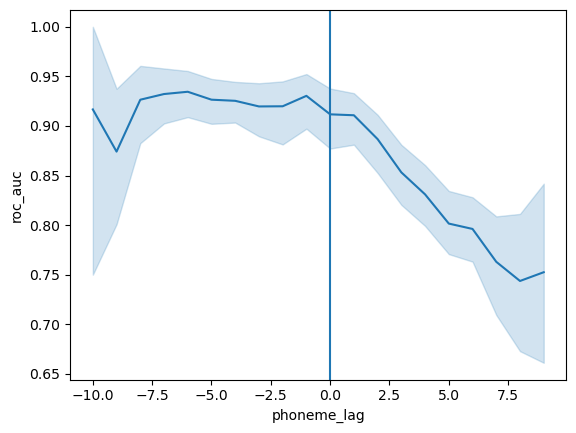

In [100]:
ax = sns.lineplot(data=roc_auc_by_phoneme_lag_df, x="phoneme_lag", y="roc_auc")
ax.axvline(0)

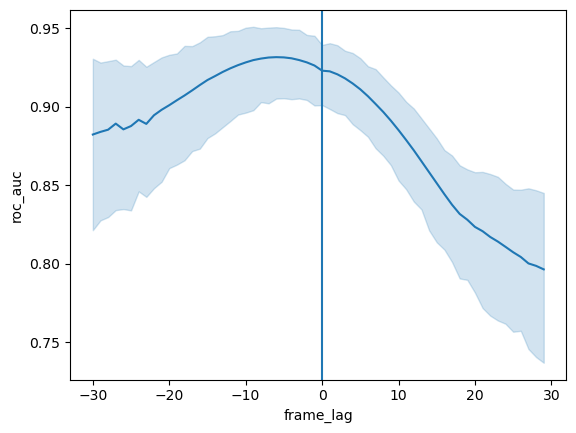

In [101]:
ax = sns.lineplot(data=roc_auc_by_frame_lag_df, x="frame_lag", y="roc_auc")
ax.axvline(0)